## 改进的main_test6的代码

In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

# 常量配置 - 根据论文调整参数
NUM_NODES = 100  # 链式网络中的节点数
SYNC_INTERVAL = 0.03125  # 同步间隔 (31.25 ms)
PHY_JITTER = 8e-9  # PHY抖动范围 (8 ns)
CLOCK_GRANULARITY = 8e-9  # 时钟粒度 (8 ns)
MAX_DRIFT_RATE = 10e-6  # 最大漂移率 (±10 ppm)
SIM_TIME = 100.0  # 仿真总时长 (秒) - 增加以获取更稳定结果
PDELAY_INTERVAL = 1.0  # 传播延迟测量间隔 (1 s)
DRIFT_RATE_CHANGE = 0.1e-6  # 漂移率每秒变化范围调低至 [0, 0.1] ppm/s

# PI控制器参数
KP = 0.1  # 比例增益
KI = 0.01  # 积分增益


class Clock:
    def __init__(self, is_grandmaster=False):
        self.is_grandmaster = is_grandmaster
        # Grandmaster时钟漂移率设为极小的非零值
        if self.is_grandmaster:
            self.drift_rate = np.random.uniform(-0.1e-6, 0.1e-6)
        else:
            # 初始漂移率在 ±10 ppm范围内，符合论文
            self.drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        self.offset = 0.0
        self.time = 0.0

    def update(self, delta_t):
        # 更符合论文的漂移率变化模型 - 温度等环境因素影响
        if not self.is_grandmaster and np.random.random() < 0.005:  # 降低变化概率，模拟温度变化
            temp_effect = np.random.normal(0, DRIFT_RATE_CHANGE)
            self.drift_rate += temp_effect * delta_t
            self.drift_rate = np.clip(self.drift_rate, -MAX_DRIFT_RATE, MAX_DRIFT_RATE)

        # 更新本地时间（考虑漂移率）
        self.time += delta_t * (1 + self.drift_rate)
        return self.time

    def adjust(self, offset):
        # 调整本地时钟的偏移量（保留漂移率的影响）
        self.offset += offset
        self.time += offset


class Node:
    def __init__(self, node_id, is_grandmaster=False):
        self.id = node_id
        self.is_grandmaster = is_grandmaster
        self.clock = Clock(is_grandmaster=self.is_grandmaster)

        # 根据论文调整物理层参数
        self.residence_time = 0.5e-6 if is_grandmaster else 1e-6  # 驻留时间，调整为更现实的微秒级
        self.propagation_delay = 50e-9  # 传播延迟固定为50ns (论文中的值)

        # 增加随机初始偏移，模拟真实启动条件
        if not is_grandmaster:
            initial_offset = np.random.uniform(-10e-6, 10e-6)  # ±10μs初始偏移
            self.clock.offset = initial_offset
            self.clock.time += initial_offset

        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.asymmetry = np.random.normal(0, 5e-9)  # 随机非对称性，均值0，标准差5ns
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        self.integral_error = 0.0  # PI控制器的积分项
        self.sync_errors = []
        self.time_errors = []  # 时间误差记录 (不取绝对值)
        self.gm_time_errors = []  # GM自身时间误差记录 (不取绝对值)

        # 性能监控
        self.mean_error = 0.0
        self.max_error = 0.0
        self.error_count = 0

    def receive_sync(self, sync_time, correction_field, network_time):
        # 接收Sync消息时添加抖动和时钟粒度
        actual_receive_time = sync_time + self.propagation_delay + \
                              np.random.uniform(-PHY_JITTER, PHY_JITTER) + \
                              np.random.uniform(-CLOCK_GRANULARITY / 2, CLOCK_GRANULARITY / 2)

        # 计算本地时间与主时钟的偏差
        local_time = self.clock.time
        gm_time = sync_time + correction_field
        error = local_time - gm_time

        # 更新性能统计
        self.error_count += 1
        self.mean_error = (self.mean_error * (self.error_count - 1) + error) / self.error_count
        self.max_error = max(self.max_error, abs(error))

        # PI控制器计算时钟调整
        self.integral_error += error
        # 积分项限幅，防止积分饱和
        self.integral_error = np.clip(self.integral_error, -1e-3, 1e-3)

        # 计算调整量
        adjustment = -KP * error - KI * self.integral_error

        # 应用有限的调整（不立即100%校正）
        self.clock.adjust(adjustment)

        # 记录时间误差（保留符号）
        if self.is_grandmaster:
            self.gm_time_errors.append((network_time, error))
        else:
            self.time_errors.append((network_time, error))

        # 添加驻留时间并转发Sync消息
        forward_time = actual_receive_time + self.residence_time
        return forward_time

    def measure_pdelay(self, neighbor):
        # 增强的传播延迟测量，更符合实际协议行为
        # 添加处理时间
        proc_time = np.random.uniform(0.5e-6, 2e-6)  # 0.5-2微秒处理时间

        t1 = self.clock.time
        # 发送延迟请求，包括处理时间和抖动
        forward_delay = self.propagation_delay + np.random.uniform(-PHY_JITTER, PHY_JITTER)
        t2 = neighbor.clock.time + forward_delay + proc_time

        # 再次添加处理时间
        proc_time = np.random.uniform(0.5e-6, 2e-6)
        t3 = neighbor.clock.time + proc_time
        # 返回路径可能有不同的延迟（非对称）
        return_delay = self.propagation_delay + np.random.uniform(-PHY_JITTER, PHY_JITTER)
        t4 = self.clock.time + return_delay + self.asymmetry  # 加入非对称性

        # 标准Pdelay计算
        mean_propagation_delay = ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2)) / 2

        # 应用指数平滑
        alpha = 0.1  # 平滑因子
        if hasattr(self, '_propagation_delay_history'):
            self.propagation_delay = (1 - alpha) * self._propagation_delay_history + alpha * mean_propagation_delay
            self._propagation_delay_history = self.propagation_delay
        else:
            self.propagation_delay = mean_propagation_delay
            self._propagation_delay_history = mean_propagation_delay

        # 更新频率比例
        if not self.is_grandmaster:
            # 使用pdelay消息估计邻居的频率比
            freq_ratio = ((t4 - t1) / (t3 - t2))
            # 平滑更新
            self.neighbor_rate_ratio = (1 - alpha) * self.neighbor_rate_ratio + alpha * freq_ratio


class Network:
    def __init__(self):
        self.nodes = [Node(i, is_grandmaster=(i == 0)) for i in range(NUM_NODES)]
        self.grandmaster = self.nodes[0]
        self.event_queue = []
        self.current_time = 0.0
        self.event_counter = 0

        # 设置初始邻居率比
        for i in range(1, NUM_NODES):
            prev_node = self.nodes[i - 1]
            curr_node = self.nodes[i]
            ideal_rate_ratio = (1 + prev_node.clock.drift_rate) / (1 + curr_node.clock.drift_rate)
            error = np.random.uniform(-0.1e-6, 0.1e-6)  # ±0.1ppm误差
            curr_node.neighbor_rate_ratio = ideal_rate_ratio * (1 + error)

    def schedule_event(self, time, callback, *args):
        heapq.heappush(self.event_queue, (time, self.event_counter, callback, args))
        self.event_counter += 1

    def run_simulation(self):
        # 初始化仿真事件
        self.schedule_event(0.0, self.track_gm_error, self.grandmaster)
        self.schedule_event(0.0, self.send_sync, self.grandmaster)
        for i in range(1, NUM_NODES):
            self.schedule_event(0.0, self.measure_pdelay, self.nodes[i], self.nodes[i - 1])

        # 运行仿真
        print(f"Starting simulation, duration: {SIM_TIME} seconds...")
        while self.event_queue and self.current_time < SIM_TIME:
            time, _, callback, args = heapq.heappop(self.event_queue)

            # 更新所有节点的时钟到当前时间
            delta_t = time - self.current_time
            for node in self.nodes:
                node.clock.update(delta_t)

            self.current_time = time
            callback(*args)

            # 显示进度
            if int(self.current_time) % 10 == 0 and int(self.current_time) > 0 and int(self.current_time) // 10 != int(
                    (self.current_time - delta_t) // 10):
                print(f"Simulation progress: {self.current_time:.1f}/{SIM_TIME} seconds")

        print("Simulation completed!")
        self.print_statistics()

    def track_gm_error(self, gm_node):
        # 记录GM与理想时间的误差
        ideal_time = self.current_time
        gm_time = gm_node.clock.time
        error = gm_time - ideal_time
        gm_node.gm_time_errors.append((self.current_time, error))
        self.schedule_event(self.current_time + SYNC_INTERVAL / 4, self.track_gm_error, gm_node)

    def send_sync(self, node):
        sync_time = self.current_time
        correction_field = 0.0

        for i in range(1, NUM_NODES):
            # 每个节点接收并更新同步消息
            forward_time = self.nodes[i].receive_sync(sync_time, correction_field, self.current_time)

            # 更新校正字段，根据IEEE 802.1AS标准
            correction_field += self.nodes[i - 1].propagation_delay  # 上一个节点到当前节点的延迟
            residence_time = forward_time - (sync_time + self.nodes[i - 1].propagation_delay)
            correction_field += residence_time * self.nodes[i].rate_ratio

            # 更新下一跳的同步时间
            sync_time = forward_time

        self.schedule_event(self.current_time + SYNC_INTERVAL, self.send_sync, node)

    def measure_pdelay(self, node, neighbor):
        node.measure_pdelay(neighbor)
        self.schedule_event(self.current_time + PDELAY_INTERVAL, self.measure_pdelay, node, neighbor)

    def print_statistics(self):
        """打印各节点性能统计"""
        print("\n=== 性能统计 ===")
        nodes_to_print = [0, 1, 10, 25, 50, 75, 99]  # 要打印的节点索引

        print("节点\t平均误差(μs)\t最大误差(μs)")
        for idx in nodes_to_print:
            node = self.nodes[idx]
            print(f"{idx}\t{node.mean_error * 1e6:.3f}\t{node.max_error * 1e6:.3f}")

    def save_errors_to_csv(self, filename="gptp_time_errors_improved.csv"):
        """将所有节点的时间误差保存到CSV文件"""
        # 创建一个包含所有时间点的集合
        all_times = set()
        for node in self.nodes:
            if node.is_grandmaster:
                for time, _ in node.gm_time_errors:
                    all_times.add(time)
            else:
                for time, _ in node.time_errors:
                    all_times.add(time)

        # 将时间点排序
        sorted_times = sorted(list(all_times))

        # 创建一个字典来存储每个节点在每个时间点的误差
        error_data = {time: [None] * NUM_NODES for time in sorted_times}

        # 填充数据 - 保留误差符号
        for i, node in enumerate(self.nodes):
            errors = node.gm_time_errors if node.is_grandmaster else node.time_errors
            for time, error in errors:
                if time in error_data:
                    error_data[time][i] = error * 1e6  # 转换为微秒，保留符号

        # 确保目录存在
        os.makedirs(os.path.dirname(os.path.abspath(filename)), exist_ok=True)

        # 写入CSV文件
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # 写入标题行
            header = ['Time (s)'] + [f'Hop {i}' for i in range(NUM_NODES)]
            writer.writerow(header)

            # 写入数据行
            for time in sorted_times:
                row = [time] + error_data[time]
                writer.writerow(row)

        print(f"时间误差数据已保存到 {filename}")

    def plot_individual_errors(self):
        """绘制单独的节点误差图"""
        # 关键节点绘制
        nodes_to_plot = [0, 1, 10, 25, 50, 75, 99]  # 0-based索引

        for node_idx in nodes_to_plot:
            node = self.nodes[node_idx]
            errors = node.gm_time_errors if node.is_grandmaster else node.time_errors

            if len(errors) > 5:  # 确保有足够的数据点
                times, error_values = zip(*errors)

                # 跳过前5个点以获得稳定数据
                start_idx = min(5, len(times) - 1)
                times = times[start_idx:]
                error_values = np.array(error_values[start_idx:]) * 1e6  # 转换为微秒

                plt.figure(figsize=(10, 6))
                plt.plot(times, error_values)
                plt.title(f'{"GM" if node.is_grandmaster else f"Hop {node_idx}"} Time Error')
                plt.xlabel('Time (s)')
                plt.ylabel('Error (μs)')
                plt.grid(True)
                plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # 添加零线

                # 自动调整Y轴范围或使用固定范围
                max_abs_error = max(abs(np.min(error_values)), abs(np.max(error_values)))
                y_limit = max(1.0, max_abs_error * 1.2)  # 至少±1μs，或者比最大误差大20%
                plt.ylim(-y_limit, y_limit)

                plt.savefig(f"hop_{node_idx}_error.png")
                plt.close()
                print(f"已保存Hop {node_idx}的误差图")

    def plot_error_comparison(self):
        """在同一图表中比较所有指定节点的时间误差"""
        nodes_to_plot = [0, 1, 10, 25, 50, 75, 99]  # 0-based索引

        plt.figure(figsize=(12, 8))

        # 找出所有要绘制节点的误差最大值以设置合适的Y轴范围
        all_errors = []
        for node_idx in nodes_to_plot:
            node = self.nodes[node_idx]
            errors = node.gm_time_errors if node.is_grandmaster else node.time_errors
            if len(errors) > 5:
                _, error_values = zip(*errors)
                error_values = np.array(error_values[5:]) * 1e6  # 跳过前5个点，转换为微秒
                all_errors.extend(error_values)

        if all_errors:
            max_abs_error = max(abs(np.min(all_errors)), abs(np.max(all_errors)))
            y_limit = max(1.0, max_abs_error * 1.2)  # 至少±1μs，或者比最大误差大20%
        else:
            y_limit = 1.0  # 默认±1μs

        for node_idx in nodes_to_plot:
            node = self.nodes[node_idx]
            errors = node.gm_time_errors if node.is_grandmaster else node.time_errors

            if len(errors) > 5:
                times, error_values = zip(*errors)

                # 跳过前5个点以获得稳定数据
                start_idx = min(5, len(times) - 1)
                times = times[start_idx:]
                error_values = np.array(error_values[start_idx:]) * 1e6  # 转换为微秒

                label = "GM" if node.is_grandmaster else f"Hop {node_idx}"
                plt.plot(times, error_values, label=label)

        plt.title('Time Error Comparison for Different Hops')
        plt.xlabel('Time (s)')
        plt.ylabel('Error (μs)')
        plt.legend()
        plt.grid(True)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # 添加零线
        plt.ylim(-y_limit, y_limit)  # 对称Y轴范围
        plt.savefig("error_comparison.png")
        plt.close()
        print("已保存误差比较图")

    def plot_error_distribution(self):
        """绘制最后25%时间内的误差分布直方图"""
        nodes_to_plot = [0, 1, 10, 25, 50, 75, 99]  # 要绘制的节点索引

        plt.figure(figsize=(14, 10))

        for i, node_idx in enumerate(nodes_to_plot):
            plt.subplot(3, 3, i + 1)

            node = self.nodes[node_idx]
            errors = node.gm_time_errors if node.is_grandmaster else node.time_errors

            if len(errors) > 0:
                # 只使用最后25%的数据（稳定状态）
                start_idx = int(len(errors) * 0.75)
                _, error_values = zip(*errors[start_idx:])
                error_values = np.array(error_values) * 1e6  # 转换为微秒

                plt.hist(error_values, bins=30, alpha=0.7)
                plt.title(f"{'GM' if node.is_grandmaster else f'Hop {node_idx}'} Error Distribution")
                plt.xlabel('Error (μs)')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)

                # 添加统计信息
                mean = np.mean(error_values)
                std = np.std(error_values)
                plt.axvline(mean, color='r', linestyle='--')
                plt.text(0.05, 0.95, f'Mean: {mean:.3f}μs\nStd: {std:.3f}μs',
                         transform=plt.gca().transAxes, verticalalignment='top')

        plt.tight_layout()
        plt.savefig("error_distribution.png")
        plt.close()
        print("已保存误差分布图")

    def plot_max_error_by_hop(self):
        """绘制每个跳数的最大误差"""
        max_errors = []
        hop_nums = []

        for i, node in enumerate(self.nodes):
            if len(node.time_errors) > 0 or len(node.gm_time_errors) > 0:
                errors = node.gm_time_errors if node.is_grandmaster else node.time_errors
                # 只使用最后25%的数据（稳定状态）
                start_idx = int(len(errors) * 0.75)
                _, error_values = zip(*errors[start_idx:])
                error_values = np.array(error_values) * 1e6  # 转换为微秒

                max_err = max(abs(np.max(error_values)), abs(np.min(error_values)))
                max_errors.append(max_err)
                hop_nums.append(i)

        plt.figure(figsize=(10, 6))
        plt.plot(hop_nums, max_errors, 'o-')
        plt.title('Maximum Absolute Error by Hop Count')
        plt.xlabel('Hop Number')
        plt.ylabel('Maximum Absolute Error (μs)')
        plt.grid(True)
        plt.savefig("max_error_by_hop.png")
        plt.close()
        print("已保存最大误差-跳数关系图")


if __name__ == "__main__":
    network = Network()
    network.run_simulation()

    # 保存所有节点的时间误差到CSV
    network.save_errors_to_csv()

    # 绘制各个节点的单独图表
    network.plot_individual_errors()

    # 绘制所有节点误差的比较图
    network.plot_error_comparison()

    # 绘制误差分布直方图
    network.plot_error_distribution()

    # 绘制最大误差与跳数的关系
    network.plot_max_error_by_hop()

## 得到csv
D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\gptp_time_errors_improved.csv

## 提取csv中的数据
保留1、10、25、50、75、100跳对应的Time (s)	Hop 0	Hop 1	Hop 9	Hop 24	Hop 49	Hop 74	Hop 99


In [ ]:
import pandas as pd

# 读取原始CSV文件
df = pd.read_csv(r'D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\gptp_time_errors_improved.csv')  # 请将'your_file.csv'替换为你的实际文件名

# 选择需要的列
selected_columns = ['Time (s)', 'Hop 0', 'Hop 1', 'Hop 9', 'Hop 24', 'Hop 49', 'Hop 74', 'Hop 99']
new_df = df[selected_columns]

# 保存到新的CSV文件
new_df.to_csv('selected_hops.csv', index=False)

print("新的CSV文件已保存为 'selected_hops.csv'")

## 得到 selected_hops.csv

## 将不是0.03125s的行数据去掉。

In [ ]:

import csv


def filter_csv(input_file, output_file, start_row=2, step=4):
    """
    过滤CSV文件，保留特定间隔的行

    参数:
        input_file: 输入CSV文件路径
        output_file: 输出CSV文件路径
        start_row: 开始保留的行号(从1开始计数)
        step: 保留的行间隔
    """
    with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
            open(output_file, 'w', newline='', encoding='utf-8') as outfile:

        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        # 写入标题行(第一行)
        header = next(reader)
        writer.writerow(header)

        # 处理数据行
        for i, row in enumerate(reader, 1):  # 从1开始计数
            if (i + 1 - start_row) % step == 0:  # 判断是否是需要保留的行
                writer.writerow(row)


if __name__ == "__main__":
    input_filename = r"/old_version/main_test6/selected_hops.csv"  # 输入文件名
    output_filename = "output.csv"  # 输出文件名

    filter_csv(input_filename, output_filename)

    print(f"处理完成，结果已保存到 {output_filename}")

## 得到 output.csv

## 对output.csv 进行画图

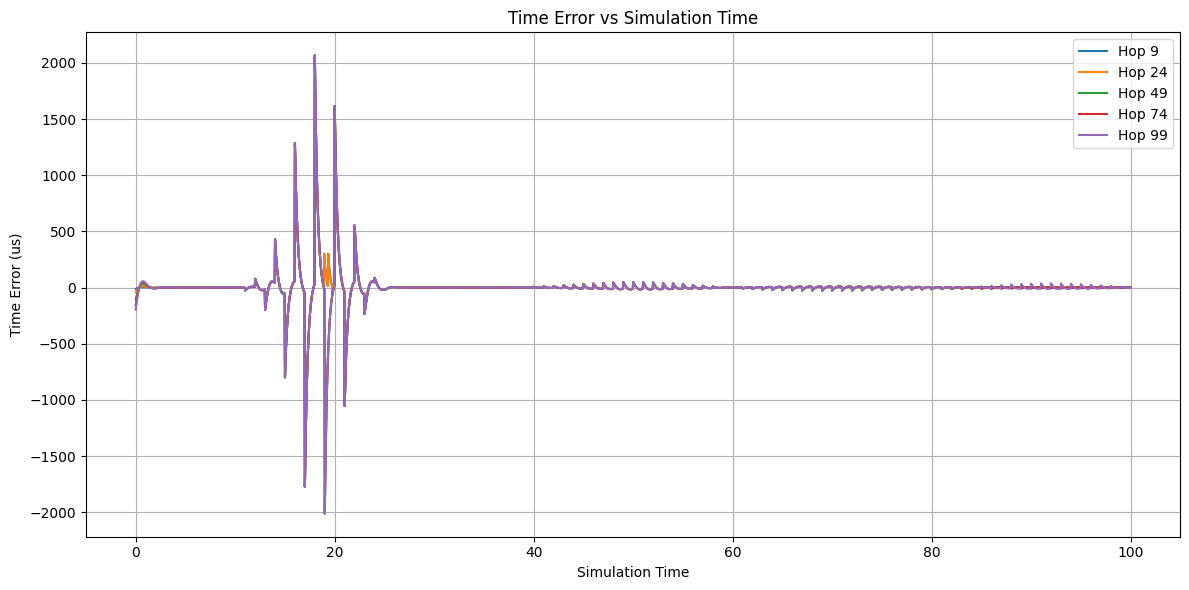

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'output.csv'  # 请替换为你的CSV文件路径
data = pd.read_csv(file_path)

# 提取列名和数据
time_column = data.columns[0]  # 假设第一列是仿真时间
error_columns = data.columns[1:]  # 从第二列到最后一列

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每条折线
for column in error_columns:
    plt.plot(data[time_column], data[column], label=column)

# 设置图表标题和坐标轴标签
plt.title('Time Error vs Simulation Time')
plt.xlabel('Simulation Time')
plt.ylabel('Time Error (us)')
plt.legend()

# 显示网格
plt.grid(True)

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()
